In [1]:
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity as cosine_loss
import cv2 as cv
from matplotlib import pyplot as plt
from Queue import Queue
from threading import Thread
import numpy as np
import random, json, itertools, requests, urllib

In [2]:
sess = tf.InteractiveSession()
IMAGE_DIM = (380, 380, 3)
model = tf.keras.applications.ResNet50(weights='imagenet', pooling=max, include_top = False)
model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
category_classifier = tf.keras.models.load_model('models/catgegory_class.h5')

/Users/coviam/image_search/pyenv/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [50]:
raw_file = []
category_map = {}
images, categories = [], []
writeQueue = Queue()
cat_label_map =  None

K = 10
POS_THETA = .8
FILE_RANGE = 37000
PRECISION = 2
SOLR_SCORE_THRESH = -1
CATEGORY_THRESH = 10
TOP_CATEGORIES_DETECTED = 2
debug = True

with open('dataset/dataset.txt') as f:
    raw_file = f.readlines()[:FILE_RANGE]
    raw_file = set(raw_file)
#     random.shuffle(raw_file)
for record in raw_file:
    data = json.loads(record)
    link = 'dataset/' + data['dir']
    for cat in data['label']:
        if not cat in category_map:
            category_map[cat] = [] 
        category_map[cat].append(link)
    images.append(link), categories.append(data['label'])
    

def get_embedding(image_np):
    feature = model.predict(image_np.reshape((1,380,380,3)))
#     feature = tf.reshape(tf.squeeze(feature), [-1])
    feature = global_average_layer(feature)
    return tf.squeeze(feature)
    
def get_dist(x, y):
    vec2 = np.array([y.eval()])
    vec1 = np.array([x.eval()])
    return cosine_loss(vec1, vec2).squeeze()
    
def sampler(pos, pos_img, neg, neg_img, dist, img):
    if dist > POS_THETA:
        if len(pos) < K:
            print "Similar Image:", img, dist
            pos.append(dist)
            pos_img.append(img)
            if debug:
                show_image(cv.imread(img))
        elif dist > max(pos):
            print "Similar Image:", img, dist
            if debug:
                show_image(cv.imread(img))
            ind = np.argmax(pos)
            pos.pop(ind), pos_img.pop(ind)
            pos.append(dist), pos_img.append(img)
    return pos, pos_img, neg, neg_img  

    
def show_image(image_np):
    plt.imshow(image_np[:,:,::-1])
    plt.show()

def get_intent_categories(image):
    scores, links = [], []
    global cat_label_map, label_map
    if cat_label_map is None:
        with open('models/cat_label.json', 'r') as f:
            cat_label_map = json.load(f)
    for index,score in enumerate(category_classifier.predict(image.reshape((1,380,380,3)))[0]):
        scores.append([score*100, index])
    top_cats = sorted(scores, key=lambda x: x[0], reverse=True)[:TOP_CATEGORIES_DETECTED]
    return [cat_label_map[index[1]] for index in top_cats if index[0] > CATEGORY_THRESH]

def write_to_queue(poss, negs, query):
    perms = [zip(x,negs) for x in itertools.permutations(poss,len(negs))]
    perms = list(itertools.chain.from_iterable(perms))
    for perm in perms:
        writeQueue.put(repr(str(query)+","+str(perm[0])+","+str(perm[1])+"\n"))
        

In [55]:
HOST = "seoulsolr6-01.dev1.lokal:8983"
COLL = "imageSearch"
# HOST = "xsearch-solr7-02.perf.lokal:8983"
# COLL = "imageSearch_flatten"
url = 'http://'+HOST+'/solr/'+COLL
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:69.0) Gecko/20100101 Firefox/69.0',
    'Accept': 'application/json, text/plain, */*, application/x-www-form-urlencoded',
    'Accept-Language': 'en-US,en;q=0.5',
    'Content-type': 'application/json',
    'Connection': 'keep-alive',
    'Referer': 'http://seoulsolr6-01.dev1.lokal:8983/solr/',
    'x-forwarded-for': 'blibli.com',
}

def convert_to_solr_vec(vec):
    return " ".join([str(x) + "|"+str(y) for x, y in zip(range(0, len(vec)), vec)])

def update_to_solr(vec, image_link, category):
    global images
    params = (
        ('_', '1570789966606'),
        ('boost', '1.0'),
        ('commitWithin', '1000'),
        ('overwrite', 'true'),
        ('wt', 'json'),
    )
    data = '[{"imageURL":"'+image_link+'", "vector":"'+convert_to_solr_vec(vec)+' ", "categories": '+json.dumps(category)+'}]'
    response = requests.post(url+'/update', headers=headers, params=params, data=data)
    print response.json(), image_link.split('/')[-1], images.index(image_link)
    
def query_to_solr(vec, categories):
    params = \
        'fl=categories,score,imageURL&'\
        'indent=on&'\
        'q={!vp f=vector vector="'+",".join(str(x) for x in vec.eval())+'"}&'\
        'fq=categories: ('+" OR ".join(categories)+')&'\
        'rows=5&'\
        'wt=json'
    response = requests.post(url+'/select', headers={"Content-Type":"application/x-www-form-urlencoded"}, data=params)
    docs = response.json()['response']['docs']
    return [doc for doc in docs if doc['score'] > SOLR_SCORE_THRESH]

In [56]:
# for image_, cat in zip(images, categories)[420:]:
#     try:
#         image_np = cv.imread(image_).squeeze()
#         vec = get_embedding(image_np).eval()
#         t = Thread(target=update_to_solr, args=(vec, image_, cat))
#         t.start()           
#     except KeyboardInterrupt:
#         raise
#     except:
#         continue    

In [57]:
def search(image_link):
    main_image = cv.imread(image_link)
    flipVertical = cv.flip(main_image, 0)
#     flipHorizontal = cv.flip(main_image, 1)
    flipBoth = cv.flip(main_image, -1)
    aug_images = [main_image, flipVertical, flipBoth]    
    for image in aug_images:
        feature = get_embedding(image)
        show_image(image)
        print image.shape
        categories = get_intent_categories(image)
        print "Categories =", categories
        for result in query_to_solr(feature, categories):
            print 'Score =', result['score']
            show_image(cv.imread(result['imageURL']))
            print "-"*70
        

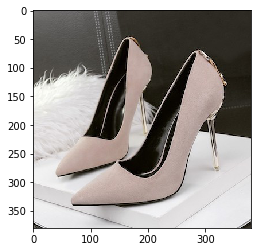

(380, 380, 3)
Categories = [u'SE-1000025', u'TA-1000023']
Score = 0.69780546


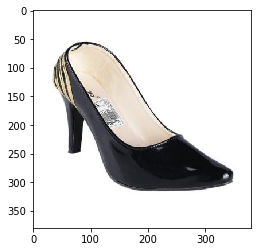

----------------------------------------------------------------------
Score = 0.69573


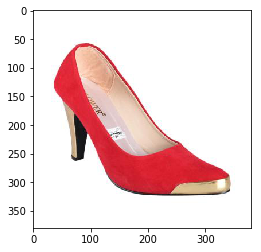

----------------------------------------------------------------------
Score = 0.69340724


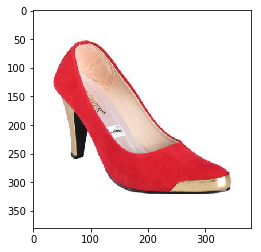

----------------------------------------------------------------------
Score = 0.69178


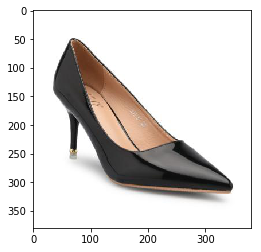

----------------------------------------------------------------------
Score = 0.6914992


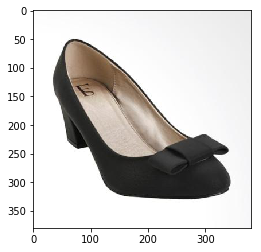

----------------------------------------------------------------------


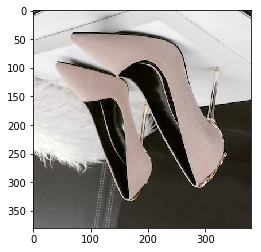

(380, 380, 3)
Categories = [u'TA-1000023', u'JA-1000110']
Score = 0.6637829


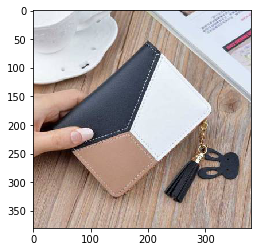

----------------------------------------------------------------------
Score = 0.6453748


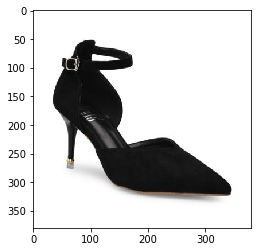

----------------------------------------------------------------------
Score = 0.64057076


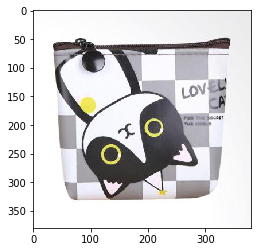

----------------------------------------------------------------------
Score = 0.6355375


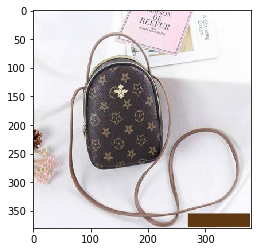

----------------------------------------------------------------------
Score = 0.62866974


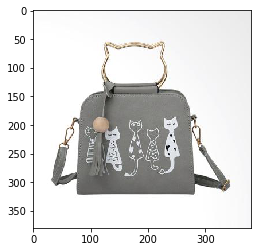

----------------------------------------------------------------------


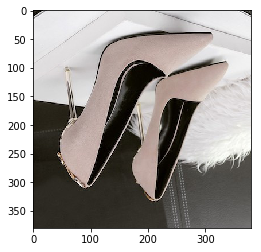

(380, 380, 3)
Categories = [u'JA-1000110', u'TA-1000023']
Score = 0.6820563


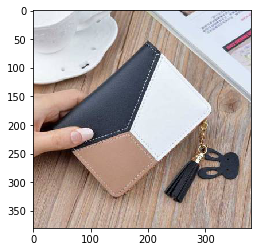

----------------------------------------------------------------------
Score = 0.6551741


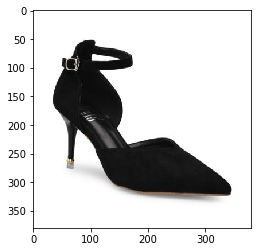

----------------------------------------------------------------------
Score = 0.6518332


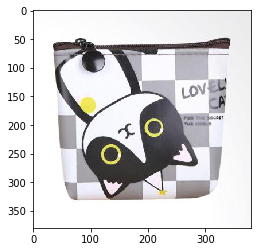

----------------------------------------------------------------------
Score = 0.6406489


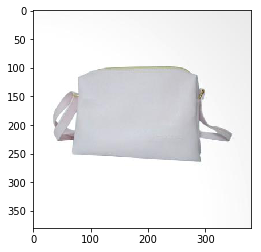

----------------------------------------------------------------------
Score = 0.63564616


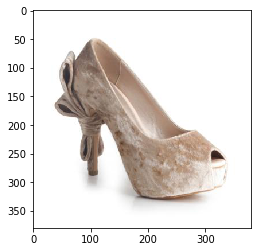

----------------------------------------------------------------------
None


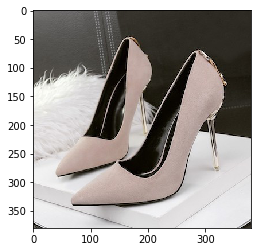

(380, 380, 3)
Categories = [u'SE-1000025', u'TA-1000023']
Score = 0.69780546


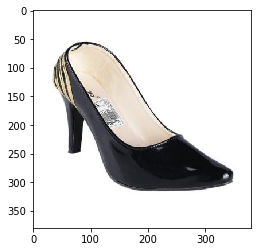

----------------------------------------------------------------------
Score = 0.69573


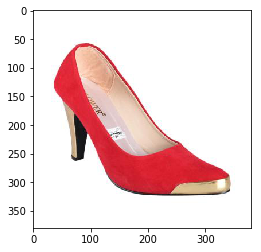

----------------------------------------------------------------------
Score = 0.69340724


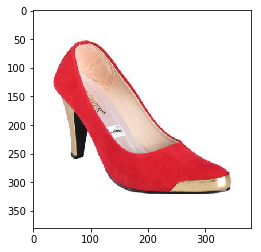

----------------------------------------------------------------------
Score = 0.69178


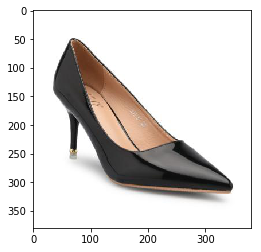

----------------------------------------------------------------------
Score = 0.6914992


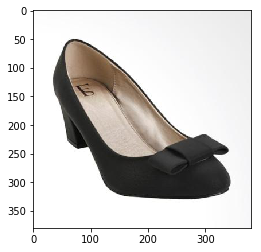

----------------------------------------------------------------------


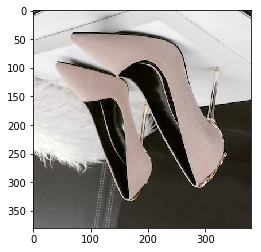

(380, 380, 3)
Categories = [u'TA-1000023', u'JA-1000110']
Score = 0.6637829


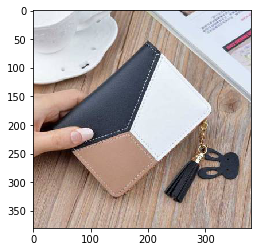

----------------------------------------------------------------------
Score = 0.6453748


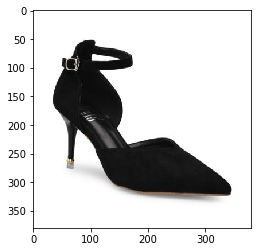

----------------------------------------------------------------------
Score = 0.64057076


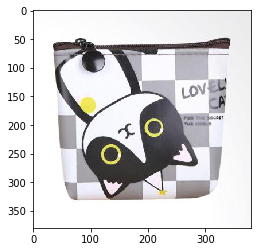

----------------------------------------------------------------------
Score = 0.6355375


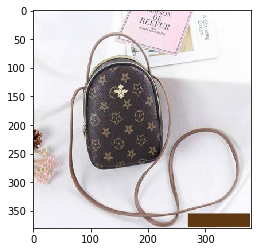

----------------------------------------------------------------------
Score = 0.62866974


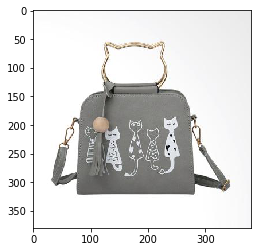

----------------------------------------------------------------------


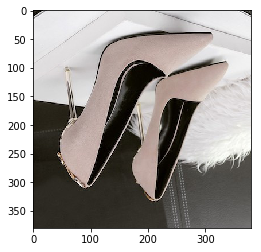

(380, 380, 3)
Categories = [u'JA-1000110', u'TA-1000023']
Score = 0.6820563


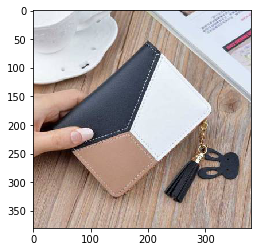

----------------------------------------------------------------------
Score = 0.6551741


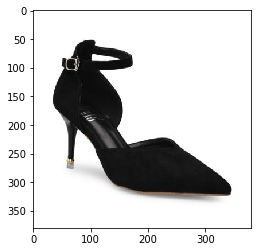

----------------------------------------------------------------------
Score = 0.6518332


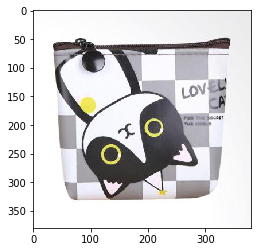

----------------------------------------------------------------------
Score = 0.6406489


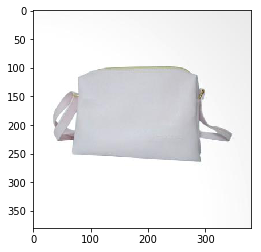

----------------------------------------------------------------------
Score = 0.63564616


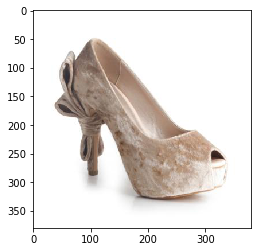

----------------------------------------------------------------------


In [58]:
image_link = '/Users/coviam/image_search/test/heels1.jpg'
print search(image_link)
search(image_link)
    